In [1]:
# 1. Imports and Setup
# 
# This notebook implements a comprehensive time series forecasting pipeline with:
# - Statistical models: Holt-Winters, AutoARIMA, Prophet
# - Deep learning models: TiDE, N-BEATS, TFT (via Darts)
# - Foundation models: Chronos (Amazon), TimeGPT (Nixtla)
#
# Key features:
# - Proper train/test split with NO data leakage
# - Cross-validation on training data only (scaler fitted on train)
# - Grid/random search for hyperparameter tuning
# - Reproducible results via RANDOM_SEED

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import random
import warnings
import logging
from itertools import product
from tqdm import tqdm

# Darts - Time Series Library
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse, mape
from darts.utils.utils import ModelMode
from darts.models import (
    ExponentialSmoothing,
    AutoARIMA,
    Prophet,
    TiDEModel,
    NBEATSModel,
    TFTModel
)

# Foundation Models (optional dependencies)
try:
    from chronos import ChronosPipeline
    import torch
    CHRONOS_AVAILABLE = True
except ImportError:
    CHRONOS_AVAILABLE = False

try:
    from nixtla import NixtlaClient
    TIMEGPT_AVAILABLE = True
except ImportError:
    TIMEGPT_AVAILABLE = False

# Load API keys from external file (not tracked by git)
sys.path.insert(0, '..')
try:
    from api_keys import NIXTLA_API_KEY
except ImportError:
    NIXTLA_API_KEY = None
    print("Warning: api_keys.py not found. Copy api_keys.template.py to api_keys.py and add your keys.")

warnings.filterwarnings("ignore")
logging.getLogger("darts").setLevel(logging.WARNING)
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

print(f"Chronos: {'Available' if CHRONOS_AVAILABLE else 'Not installed'}")
print(f"TimeGPT: {'Available' if TIMEGPT_AVAILABLE else 'Not installed'}")

Chronos: Available
TimeGPT: Available


Dataset: ECB EUR/CZK Monthly Exchange Rate
Total: 385 | Train: 361 | Test: 24
Train period: 1993-12-01 to 2023-12-01
Test period:  2024-01-01 to 2025-12-01
Seasonal period: 12


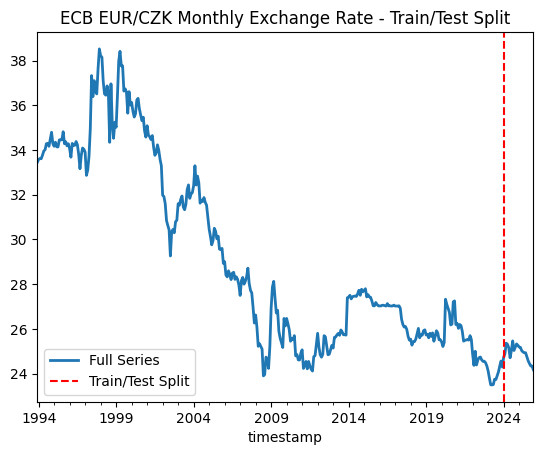

In [2]:
# 2. Data Loading and Configuration
#
# DATASET_CONFIG serves as a template for different datasets.
# Simply uncomment the desired configuration or create a new one.

# === ACTIVE DATASET CONFIGURATION ===
DATASET_CONFIG = {
    'file_path': '../datasets/ecb_eurczk_monthly.csv',
    'time_column': 'timestamp',
    'target_column': 'eur_czk',
    'frequency': 'MS',          # 'MS'=monthly start, 'QS'=quarterly, 'YS'=yearly, 'H'=hourly, 'D'=daily
    'test_periods': 24,         # Number of periods to hold out for testing
    'seasonal_period': 12,      # 12=monthly, 4=quarterly, 1=yearly, 24=hourly, 7=daily
    'name': 'ECB EUR/CZK Monthly Exchange Rate'
}

# === ALTERNATIVE DATASET CONFIGS (uncomment to use) ===
# DATASET_CONFIG = {
#     'file_path': '../datasets/wb_usa_real_gdp_yearly.csv',
#     'time_column': 'timestamp', 'target_column': 'real_gdp',
#     'frequency': 'YS', 'test_periods': 10, 'seasonal_period': 1,
#     'name': 'World Bank USA Real GDP Yearly'
# }

# DATASET_CONFIG = {
#     'file_path': '../datasets/fred_gpdic1_investments_quarterly.csv',
#     'time_column': 'timestamp', 'target_column': 'gpdic1',
#     'frequency': 'QS', 'test_periods': 8, 'seasonal_period': 4,
#     'name': 'FRED GPDIC1 Investments Quarterly'
# }

# DATASET_CONFIG = {
#     'file_path': '../datasets/m5_walmart_hobbies_daily.csv',
#     'time_column': 'timestamp', 'target_column': 'sales',
#     'frequency': 'D', 'test_periods': 28, 'seasonal_period': 7,
#     'name': 'M5 Walmart Hobbies Daily'
# }

# DATASET_CONFIG = {
#     'file_path': '../datasets/kaggle_btcusd_hourly.csv',
#     'time_column': 'timestamp', 'target_column': 'close',
#     'frequency': 'H', 'test_periods': 168, 'seasonal_period': 24,
#     'name': 'Kaggle BTC/USD Hourly'
# }

# === LOAD AND PREPROCESS DATA ===
df = pd.read_csv(DATASET_CONFIG['file_path'])
df[DATASET_CONFIG['time_column']] = pd.to_datetime(df[DATASET_CONFIG['time_column']])
series = TimeSeries.from_dataframe(df, DATASET_CONFIG['time_column'], DATASET_CONFIG['target_column'])
series = series.astype(np.float32)

# === TRAIN/TEST SPLIT ===
# Test set is held out completely - models never see it during training or validation
freq = DATASET_CONFIG['frequency']
test_periods = DATASET_CONFIG['test_periods']
offset_map = {
    'MS': pd.DateOffset(months=test_periods), 
    'QS': pd.DateOffset(months=test_periods * 3),
    'YS': pd.DateOffset(years=test_periods), 
    'D': pd.DateOffset(days=test_periods),
    'H': pd.DateOffset(hours=test_periods)
}
offset = offset_map.get(freq, pd.DateOffset(days=test_periods))

train, test = series.split_after(pd.Timestamp(series.end_time()) - offset)

# === SCALING (for Deep Learning models) ===
# IMPORTANT: Scaler is fitted ONLY on training data to prevent data leakage
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)  # Transform only, no fitting
series_scaled = scaler.transform(series)

print(f"Dataset: {DATASET_CONFIG['name']}")
print(f"Total: {len(series)} | Train: {len(train)} | Test: {len(test)}")
print(f"Train period: {train.start_time().date()} to {train.end_time().date()}")
print(f"Test period:  {test.start_time().date()} to {test.end_time().date()}")
print(f"Seasonal period: {DATASET_CONFIG['seasonal_period']}")

series.plot(label='Full Series')
plt.axvline(x=test.start_time(), color='red', linestyle='--', label='Train/Test Split')
plt.title(f"{DATASET_CONFIG['name']} - Train/Test Split")
plt.legend()
plt.show()

In [3]:
# 3. Evaluation Metrics and Result Logging
#
# Metrics used:
# - RMSE (Root Mean Squared Error): penalizes large errors more heavily
# - MAPE (Mean Absolute Percentage Error): scale-independent, intuitive interpretation

results = []

def log_result(model_name, rmse_val, mape_val, tuning_time, best_config_time, params=None, n_combinations=1):
    """
    Log model evaluation results for later comparison.
    
    Args:
        model_name: Name of the model
        rmse_val: Root Mean Squared Error on validation set
        mape_val: Mean Absolute Percentage Error on validation set
        tuning_time: Total time for hyperparameter search
        best_config_time: Time to train and evaluate best configuration
        params: Best hyperparameters found
        n_combinations: Number of hyperparameter combinations tried
    """
    results.append({
        'Model': model_name, 'RMSE': rmse_val, 'MAPE': mape_val,
        'Tuning Time (s)': tuning_time, 'Best Config Time (s)': best_config_time,
        'Combinations': n_combinations, 'Params': params
    })
    print(f"{model_name}: RMSE={rmse_val:.4f} | MAPE={mape_val:.2f}% | Time={tuning_time:.1f}s ({n_combinations} combinations)")

def get_results_df():
    """Return results as a DataFrame sorted by RMSE (ascending)."""
    return pd.DataFrame(results).sort_values(by='RMSE')

In [4]:
# 4. Hyperparameter Tuning (Grid/Random Search) with Cross-Validation
# 
# Key Design Decisions:
# - Scaler is ONLY fitted on training data to prevent data leakage
# - Historical forecasts use rolling window validation (start=0.7 of training set)
# - Metrics are computed on properly aligned time indices

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def grid_search_all(param_grid):
    """Generate all parameter combinations for full grid search."""
    if not param_grid:
        return [{}]
    keys, values = list(param_grid.keys()), list(param_grid.values())
    return [dict(zip(keys, combo)) for combo in product(*values)]

def random_grid_search(param_grid, n_iter=5, seed=RANDOM_SEED):
    """Generate random parameter combinations with reproducible seed."""
    rng = random.Random(seed)
    keys = list(param_grid.keys())
    if not keys:
        return [{}]
    
    combinations = [{key: rng.choice(param_grid[key]) for key in keys} for _ in range(n_iter)]
    seen = set()
    return [d for d in combinations if not (key := frozenset((k, str(v)) for k, v in d.items())) in seen and not seen.add(key)]

def evaluate_model(model_cls, params, series_train, series_val, is_dl=False, forecast_horizon=12, stride=1, scaler=None, original_train=None):
    """
    Evaluate model using rolling window cross-validation on training data only.
    
    Args:
        model_cls: Model class to instantiate
        params: Hyperparameters for the model
        series_train: Training series (scaled for DL, original for statistical)
        series_val: Not used (kept for API compatibility)
        is_dl: Whether model is deep learning (requires pre-training)
        forecast_horizon: Number of steps to forecast
        stride: Step size for rolling window
        scaler: Scaler object for inverse transform (DL models only)
        original_train: Original unscaled training series (DL models only)
    
    Returns:
        Tuple of (RMSE, MAPE, execution_time)
    
    Note: No test data is used here - validation is done on the training set only.
    """
    start_time = time.time()
    try:
        model = model_cls(**params)
        if is_dl:
            # DL models: fit once, then historical forecasts without retraining
            model.fit(series_train, verbose=False)
            backtest = model.historical_forecasts(
                series=series_train, start=0.7, forecast_horizon=forecast_horizon,
                stride=stride, retrain=False, verbose=False, last_points_only=True
            )
            # Inverse transform predictions back to original scale
            backtest_unscaled = scaler.inverse_transform(backtest)
            # Get the corresponding actual values (aligned with backtest time index)
            actual = original_train.slice_intersect(backtest_unscaled)
        else:
            # Statistical models: retrain at each step
            backtest = model.historical_forecasts(
                series=series_train, start=0.7, forecast_horizon=forecast_horizon,
                stride=stride, retrain=True, verbose=False, last_points_only=True
            )
            # Align actual values with backtest time index
            actual = series_train.slice_intersect(backtest)
        
        return rmse(actual, backtest_unscaled if is_dl else backtest), mape(actual, backtest_unscaled if is_dl else backtest), time.time() - start_time
    except Exception as e:
        print(f"Error evaluating {getattr(model_cls, '__name__', str(model_cls))}: {e}")
        return float('inf'), float('inf'), 0

def run_tuning_and_eval(model_name, model_cls, param_grid, train_series, is_dl=False, 
                        n_iter=5, scaler=None, original_train=None, use_full_grid=False):
    """
    Run hyperparameter tuning with cross-validation and log results.
    
    Args:
        model_name: Name for logging
        model_cls: Model class
        param_grid: Dictionary of hyperparameters to search
        train_series: Training data (scaled for DL models)
        is_dl: Whether model is deep learning based
        n_iter: Number of random search iterations
        scaler: Scaler object (for DL models, fitted on training data only)
        original_train: Original unscaled training data (for DL models)
        use_full_grid: If True, use full grid search instead of random search
    
    Returns:
        Best hyperparameters found
    """
    tuning_start = time.time()
    
    if not param_grid:
        rmse_val, mape_val, cfg_time = evaluate_model(model_cls, {}, train_series, None, is_dl=is_dl, scaler=scaler, original_train=original_train)
        if rmse_val != float('inf'):
            log_result(model_name, rmse_val, mape_val, time.time() - tuning_start, cfg_time, {}, 1)
        return {}
    
    combinations = grid_search_all(param_grid) if use_full_grid else random_grid_search(param_grid, n_iter=n_iter, seed=RANDOM_SEED)
    best_rmse, best_params, best_mape, best_cfg_time = float('inf'), None, 0, 0
    
    for params in tqdm(combinations, desc=model_name):
        rmse_val, mape_val, cfg_time = evaluate_model(model_cls, params, train_series, None, is_dl=is_dl, scaler=scaler, original_train=original_train)
        if rmse_val < best_rmse:
            best_rmse, best_params, best_mape, best_cfg_time = rmse_val, params, mape_val, cfg_time
    
    if best_params and best_rmse != float('inf'):
        log_result(model_name, best_rmse, best_mape, time.time() - tuning_start, best_cfg_time, best_params, len(combinations))
    return best_params

In [5]:
# 5. Statistical Models (Darts)
#
# These models are trained on ORIGINAL (unscaled) data.
# Validation uses rolling window cross-validation on training data only.

SEASONAL_PERIOD = DATASET_CONFIG['seasonal_period']

# Holt-Winters (Exponential Smoothing with trend and seasonality)
hw_grid = {
    'seasonal_periods': [SEASONAL_PERIOD],
    'trend': [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
    'seasonal': [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
    'damped': [True, False]
}
run_tuning_and_eval("Holt-Winters", ExponentialSmoothing, hw_grid, train, use_full_grid=True)

# AutoARIMA (Automatic ARIMA model selection)
try:
    AutoARIMA()
    arima_grid = {
        'season_length': [SEASONAL_PERIOD],
        'seasonal': [True] if SEASONAL_PERIOD > 1 else [False],
        'max_p': [5], 'max_q': [5], 'max_P': [2], 'max_Q': [2], 'max_D': [1],
    }
    run_tuning_and_eval("AutoARIMA", AutoARIMA, arima_grid, train, use_full_grid=True)
except Exception as e:
    print(f"AutoARIMA not available: {e}")

# Prophet (Facebook's additive regression model)
try:
    Prophet()
    prophet_grid = {
        'seasonality_mode': ['additive', 'multiplicative'],
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5]
    }
    run_tuning_and_eval("Prophet", Prophet, prophet_grid, train, use_full_grid=True)
except Exception as e:
    print(f"Prophet not available: {e}")

Holt-Winters:  67%|██████▋   | 12/18 [01:10<00:34,  5.70s/it]

Error evaluating ExponentialSmoothing: Can only dampen the trend component


Holt-Winters:  89%|████████▉ | 16/18 [01:11<00:04,  2.12s/it]

Error evaluating ExponentialSmoothing: Can only dampen the trend component
Error evaluating ExponentialSmoothing: Can only dampen the trend component


Holt-Winters: 100%|██████████| 18/18 [01:12<00:00,  4.00s/it]


Holt-Winters: RMSE=0.8055 | MAPE=2.54% | Time=72.0s (18 combinations)


AutoARIMA: 100%|██████████| 1/1 [00:13<00:00, 13.17s/it]


AutoARIMA: RMSE=0.8981 | MAPE=2.87% | Time=13.2s (1 combinations)


Prophet: 100%|██████████| 8/8 [00:59<00:00,  7.45s/it]

Prophet: RMSE=1.2964 | MAPE=3.86% | Time=59.6s (8 combinations)


In [6]:
# 6. Deep Learning Models (Darts)
# 
# Note: All DL models are trained on SCALED data (scaler fitted on train only)
# to prevent data leakage. Predictions are inverse-transformed for evaluation.

base_chunk = SEASONAL_PERIOD
common_dl_params = {
    'input_chunk_length': [base_chunk, base_chunk * 2],
    'output_chunk_length': [1, base_chunk // 2 if base_chunk > 2 else 1, base_chunk],
    'n_epochs': [10, 20],
    'random_state': [RANDOM_SEED]
}

# TiDE (Time-series Dense Encoder)
tide_grid = {**common_dl_params, 'hidden_size': [64, 128], 'dropout': [0.1, 0.2],
             'num_encoder_layers': [1, 2], 'num_decoder_layers': [1, 2]}
run_tuning_and_eval("TiDE", TiDEModel, tide_grid, train_scaled, is_dl=True, 
                    n_iter=10, scaler=scaler, original_train=train)

# N-BEATS (Neural Basis Expansion Analysis)
nbeats_grid = {**common_dl_params, 'num_stacks': [10, 20], 'num_blocks': [1, 2], 'layer_widths': [128, 256]}
run_tuning_and_eval("N-BEATS", NBEATSModel, nbeats_grid, train_scaled, is_dl=True, 
                    n_iter=10, scaler=scaler, original_train=train)

# TFT (Temporal Fusion Transformer)
tft_grid = {**common_dl_params, 'hidden_size': [16, 32], 'lstm_layers': [1],
            'num_attention_heads': [4], 'dropout': [0.1], 'add_relative_index': [True]}
run_tuning_and_eval("TFT", TFTModel, tft_grid, train_scaled, is_dl=True, 
                    n_iter=10, scaler=scaler, original_train=train)

TiDE:   0%|          | 0/10 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TiDE:  10%|█         | 1/10 [00:01<00:10,  1.21s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TiDE:  20%|██        | 2/10 [00:01<00:06,  1.19it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TiDE:  30%|███    

TiDE: RMSE=0.7906 | MAPE=2.64% | Time=8.4s (10 combinations)


N-BEATS:   0%|          | 0/9 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
N-BEATS:  11%|█         | 1/9 [00:03<00:28,  3.51s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
N-BEATS:  22%|██▏       | 2/9 [00:06<00:24,  3.45s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
N-BEATS:  33

N-BEATS: RMSE=0.8535 | MAPE=2.80% | Time=45.8s (9 combinations)


TFT:   0%|          | 0/8 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TFT:  12%|█▎        | 1/8 [00:04<00:32,  4.68s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TFT:  25%|██▌       | 2/8 [00:06<00:19,  3.29s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TFT:  38%|███▊      | 3/

TFT: RMSE=2.3403 | MAPE=6.77% | Time=27.7s (8 combinations)


{'input_chunk_length': 12,
 'output_chunk_length': 1,
 'n_epochs': 20,
 'random_state': 42,
 'hidden_size': 16,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.1,
 'add_relative_index': True}

In [7]:
# 7. Foundation Models (Chronos, TimeGPT)
#
# Pre-trained models that can forecast without extensive hyperparameter tuning.
# These models are evaluated directly on the test set (zero-shot forecasting).

# Chronos (Amazon) - Runs locally, no API key needed
if CHRONOS_AVAILABLE:
    try:
        start_time = time.time()
        pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-small",
            device_map="mps" if torch.backends.mps.is_available() else "cpu",
            torch_dtype=torch.float32
        )
        # Chronos uses the full training history as context
        context = torch.tensor(train.values().flatten())
        forecast = pipeline.predict(context, prediction_length=len(test), num_samples=20)
        pred_values = forecast.median(dim=1).values.numpy().flatten()[:len(test)]
        pred_chronos = TimeSeries.from_times_and_values(times=test.time_index, values=pred_values)
        chronos_time = time.time() - start_time
        log_result("Chronos", rmse(test, pred_chronos), mape(test, pred_chronos), 
                   chronos_time, chronos_time, {'model': 'chronos-t5-small'}, 1)
    except Exception as e:
        print(f"Chronos error: {e}")

# TimeGPT (Nixtla) - Requires API key
if TIMEGPT_AVAILABLE and NIXTLA_API_KEY:
    try:
        start_time = time.time()
        nixtla_client = NixtlaClient(api_key=NIXTLA_API_KEY)
        try:
            train_df = train.pd_dataframe().reset_index()
        except AttributeError:
            train_df = pd.DataFrame({'ds': train.time_index, 'y': train.values().flatten()})
        train_df.columns = ['ds', 'y']
        forecast_df = nixtla_client.forecast(df=train_df, h=len(test), model='timegpt-1', freq=DATASET_CONFIG['frequency'])
        pred_timegpt = TimeSeries.from_times_and_values(times=test.time_index, values=forecast_df['TimeGPT'].values)
        timegpt_time = time.time() - start_time
        log_result("TimeGPT", rmse(test, pred_timegpt), mape(test, pred_timegpt),
                   timegpt_time, timegpt_time, {'model': 'timegpt-1'}, 1)
    except Exception as e:
        print(f"TimeGPT error: {e}")

`torch_dtype` is deprecated! Use `dtype` instead!
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


Chronos: RMSE=0.6867 | MAPE=2.50% | Time=2.1s (1 combinations)


INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


TimeGPT: RMSE=0.7975 | MAPE=2.84% | Time=1.2s (1 combinations)


=== Cross-Validation Results (Training Data) ===
       Model     RMSE     MAPE  Tuning Time (s)  Combinations
     Chronos 0.686724 2.497415         2.128805             1
        TiDE 0.790585 2.636333         8.429748            10
     TimeGPT 0.797468 2.837711         1.159583             1
Holt-Winters 0.805530 2.544134        72.029788            18
     N-BEATS 0.853470 2.803128        45.827097             9
   AutoARIMA 0.898150 2.869939        13.173053             1
     Prophet 1.296377 3.855752        59.599160             8
         TFT 2.340295 6.765427        27.682193             8


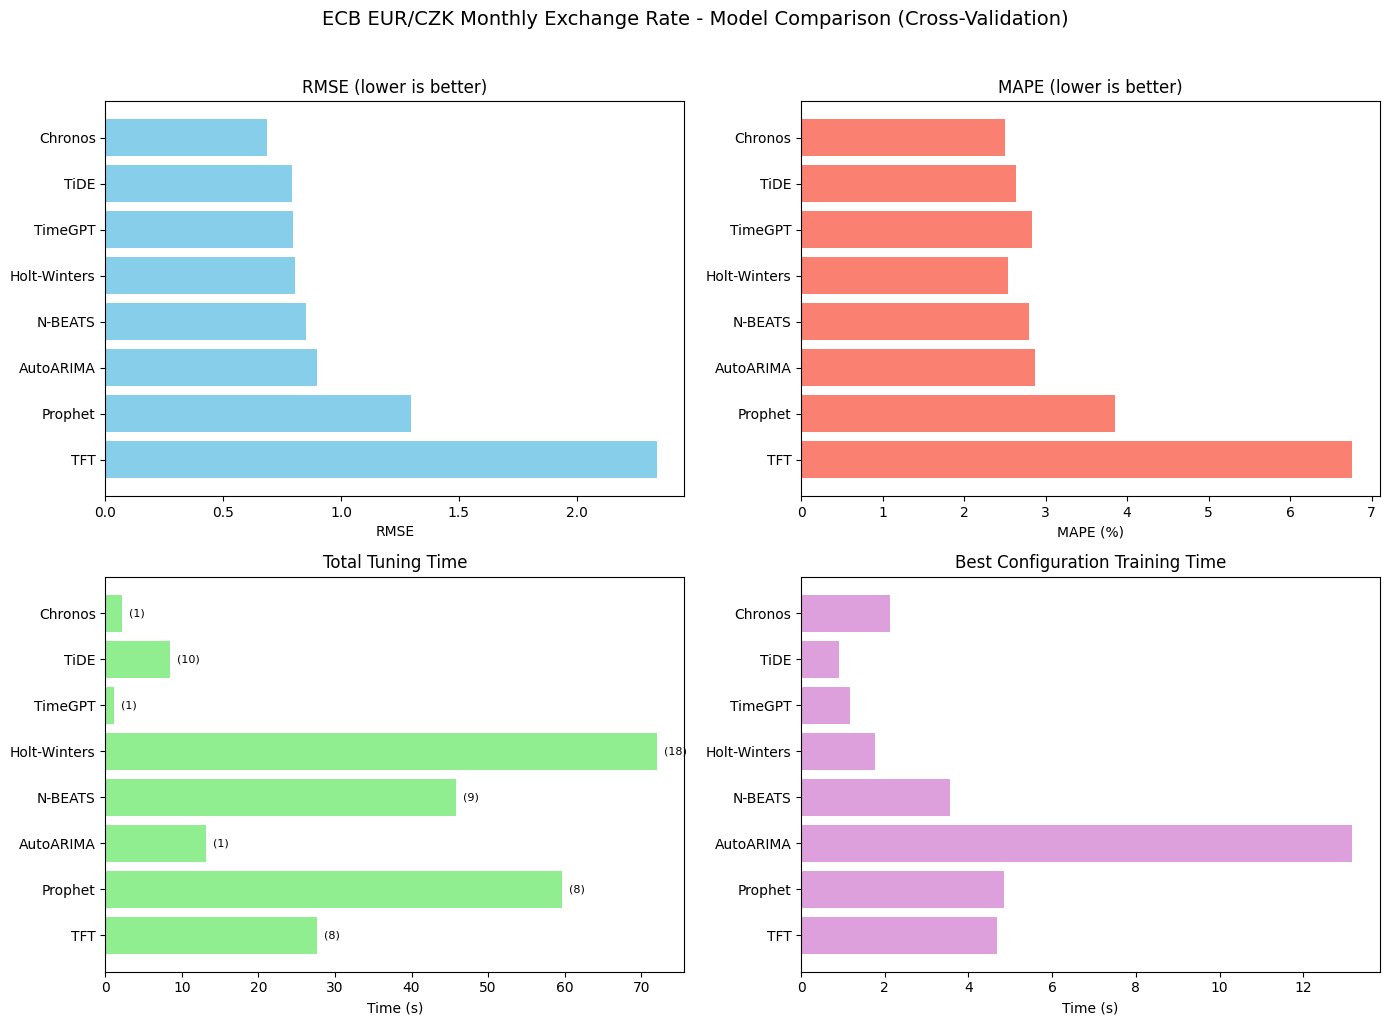


Best RMSE (CV): Chronos (0.6867)
Best MAPE (CV): Chronos (2.50%)
Fastest: TimeGPT (1.16s)


In [8]:
# 8. Results Comparison (Cross-Validation Metrics)
#
# Note: These are VALIDATION metrics from cross-validation on training data.
# Final out-of-sample test metrics are computed in Section 9.

results_df = get_results_df()
print("=== Cross-Validation Results (Training Data) ===")
print(results_df[['Model', 'RMSE', 'MAPE', 'Tuning Time (s)', 'Combinations']].to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].barh(results_df['Model'], results_df['RMSE'], color='skyblue')
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('RMSE (lower is better)')
axes[0, 0].invert_yaxis()

axes[0, 1].barh(results_df['Model'], results_df['MAPE'], color='salmon')
axes[0, 1].set_xlabel('MAPE (%)')
axes[0, 1].set_title('MAPE (lower is better)')
axes[0, 1].invert_yaxis()

axes[1, 0].barh(results_df['Model'], results_df['Tuning Time (s)'], color='lightgreen')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_title('Total Tuning Time')
axes[1, 0].invert_yaxis()
for i, (model, combos) in enumerate(zip(results_df['Model'], results_df['Combinations'])):
    axes[1, 0].annotate(f'({combos})', xy=(results_df['Tuning Time (s)'].iloc[i], i), 
                        xytext=(5, 0), textcoords='offset points', va='center', fontsize=8)

axes[1, 1].barh(results_df['Model'], results_df['Best Config Time (s)'], color='plum')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_title('Best Configuration Training Time')
axes[1, 1].invert_yaxis()

plt.suptitle(f'{DATASET_CONFIG["name"]} - Model Comparison (Cross-Validation)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nBest RMSE (CV): {results_df.iloc[0]['Model']} ({results_df.iloc[0]['RMSE']:.4f})")
print(f"Best MAPE (CV): {results_df.sort_values('MAPE').iloc[0]['Model']} ({results_df.sort_values('MAPE').iloc[0]['MAPE']:.2f}%)")
print(f"Fastest: {results_df.sort_values('Tuning Time (s)').iloc[0]['Model']} ({results_df.sort_values('Tuning Time (s)').iloc[0]['Tuning Time (s)']:.2f}s)")

In [9]:
# 9. Final Predictions with Best and Fastest Models
#
# This section trains the best models on the FULL training set and generates
# out-of-sample forecasts for the held-out test set.

def train_and_predict(model_name, params, is_dl):
    """
    Train model on full training set and return out-of-sample predictions.
    
    Args:
        model_name: Name of the model
        params: Best hyperparameters from tuning
        is_dl: Whether model is deep learning based
    
    Returns:
        TimeSeries object with predictions aligned to test period
    """
    # Foundation Models (special handling)
    if model_name == "Chronos" and CHRONOS_AVAILABLE:
        pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small",
            device_map="mps" if torch.backends.mps.is_available() else "cpu", torch_dtype=torch.float32)
        context = torch.tensor(train.values().flatten())
        forecast = pipeline.predict(context, prediction_length=len(test), num_samples=20)
        return TimeSeries.from_times_and_values(times=test.time_index, 
                                                 values=forecast.median(dim=1).values.numpy().flatten()[:len(test)])
    
    if model_name == "TimeGPT" and TIMEGPT_AVAILABLE and NIXTLA_API_KEY:
        nixtla_client = NixtlaClient(api_key=NIXTLA_API_KEY)
        try:
            train_df = train.pd_dataframe().reset_index()
        except AttributeError:
            train_df = pd.DataFrame({'ds': train.time_index, 'y': train.values().flatten()})
        train_df.columns = ['ds', 'y']
        forecast_df = nixtla_client.forecast(df=train_df, h=len(test), model='timegpt-1', freq=DATASET_CONFIG['frequency'])
        return TimeSeries.from_times_and_values(times=test.time_index, values=forecast_df['TimeGPT'].values)
    
    # Standard Darts Models
    model_map = {"Holt-Winters": ExponentialSmoothing, "AutoARIMA": AutoARIMA, "Prophet": Prophet,
                 "TiDE": TiDEModel, "N-BEATS": NBEATSModel, "TFT": TFTModel}
    if model_name not in model_map:
        return None
    
    model = model_map[model_name](**params)
    if is_dl:
        # DL models: train on scaled data, inverse transform predictions
        model.fit(train_scaled, verbose=False)
        pred_scaled = model.predict(len(test))
        return scaler.inverse_transform(pred_scaled)
    else:
        # Statistical models: train on original data
        model.fit(train)
        return model.predict(len(test))

final_predictions = {}

if not results_df.empty:
    # Best RMSE model
    best_row = results_df.iloc[0]
    is_dl_best = best_row['Model'] in ["TiDE", "N-BEATS", "TFT"]
    
    # Fastest model
    fastest_row = results_df.sort_values('Tuning Time (s)').iloc[0]
    is_dl_fast = fastest_row['Model'] in ["TiDE", "N-BEATS", "TFT"]
    
    print(f"Best RMSE: {best_row['Model']} | RMSE: {best_row['RMSE']:.4f} | MAPE: {best_row['MAPE']:.2f}%")
    print(f"Fastest: {fastest_row['Model']} | RMSE: {fastest_row['RMSE']:.4f} | Time: {fastest_row['Tuning Time (s)']:.1f}s")
    
    pred_best = train_and_predict(best_row['Model'], best_row['Params'], is_dl_best)
    if pred_best is not None:
        # Compute TRUE out-of-sample metrics on test set
        test_rmse = rmse(test, pred_best)
        test_mape = mape(test, pred_best)
        print(f"\n[OUT-OF-SAMPLE] {best_row['Model']}: RMSE={test_rmse:.4f} | MAPE={test_mape:.2f}%")
        
        final_predictions['best_rmse'] = {
            'model': best_row['Model'], 'prediction': pred_best, 'params': best_row['Params'],
            'rmse': test_rmse, 'mape': test_mape,  # Use actual test metrics
            'tuning_time': best_row['Tuning Time (s)'], 'combinations': best_row['Combinations']
        }
    
    if fastest_row['Model'] == best_row['Model']:
        final_predictions['fastest'] = final_predictions.get('best_rmse')
    else:
        pred_fast = train_and_predict(fastest_row['Model'], fastest_row['Params'], is_dl_fast)
        if pred_fast is not None:
            test_rmse_fast = rmse(test, pred_fast)
            test_mape_fast = mape(test, pred_fast)
            print(f"[OUT-OF-SAMPLE] {fastest_row['Model']}: RMSE={test_rmse_fast:.4f} | MAPE={test_mape_fast:.2f}%")
            
            final_predictions['fastest'] = {
                'model': fastest_row['Model'], 'prediction': pred_fast, 'params': fastest_row['Params'],
                'rmse': test_rmse_fast, 'mape': test_mape_fast,  # Use actual test metrics
                'tuning_time': fastest_row['Tuning Time (s)'], 'combinations': fastest_row['Combinations']
            }
    
    print("\nPredictions ready for visualization.")

Best RMSE: Chronos | RMSE: 0.6867 | MAPE: 2.50%
Fastest: TimeGPT | RMSE: 0.7975 | Time: 1.2s


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...



[OUT-OF-SAMPLE] Chronos: RMSE=0.4717 | MAPE=1.59%


INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


[OUT-OF-SAMPLE] TimeGPT: RMSE=0.7975 | MAPE=2.84%

Predictions ready for visualization.


In [10]:
# 10. Interactive Visualization (Plotly)
#
# Interactive forecast comparison with zoom, pan, and hover capabilities.

def create_interactive_forecast_plot(train_series, test_series, predictions_dict, dataset_name, target_column=None):
    """
    Create interactive forecast comparison plot using Plotly.
    
    Args:
        train_series: Training TimeSeries
        test_series: Test TimeSeries (actual values)
        predictions_dict: Dictionary with 'best_rmse' and 'fastest' predictions
        dataset_name: Name for the plot title
        target_column: Name of the target variable
    
    Returns:
        Plotly Figure object
    """
    n_plots = len([k for k in ['best_rmse', 'fastest'] if predictions_dict.get(k)])
    if n_plots == 0:
        print("No predictions to display.")
        return None
    
    same_model = predictions_dict.get('best_rmse', {}).get('model') == predictions_dict.get('fastest', {}).get('model')
    if same_model:
        n_plots = 1
    
    fig = make_subplots(rows=1, cols=n_plots, horizontal_spacing=0.08)
    
    colors = {'train': '#1f77b4', 'test': '#2ca02c', 'pred1': '#d62728', 'pred2': '#ff7f0e'}
    
    def add_traces(pred_key, col, show_legend=True, show_forecast_legend_only=False):
        """Add traces for train, test, and prediction to a subplot."""
        if pred_key not in predictions_dict:
            return
        pred_info = predictions_dict[pred_key]
        pred = pred_info['prediction']
        
        fig.add_trace(go.Scatter(
            x=train_series.time_index, y=train_series.values().flatten(),
            mode='lines', name='Train', line=dict(color=colors['train'], width=1.5),
            showlegend=show_legend and not show_forecast_legend_only, 
            hovertemplate='<b>Train</b><br>Date: %{x}<br>Value: %{y:.4f}<extra></extra>'
        ), row=1, col=col)
        
        fig.add_trace(go.Scatter(
            x=test_series.time_index, y=test_series.values().flatten(),
            mode='lines', name='Test (Actual)', line=dict(color=colors['test'], width=2),
            showlegend=show_legend and not show_forecast_legend_only, 
            hovertemplate='<b>Actual</b><br>Date: %{x}<br>Value: %{y:.4f}<extra></extra>'
        ), row=1, col=col)
        
        pred_color = colors['pred1'] if col == 1 else colors['pred2']
        fig.add_trace(go.Scatter(
            x=pred.time_index, y=pred.values().flatten(),
            mode='lines', name=f'Forecast ({pred_info["model"]})', 
            line=dict(color=pred_color, width=2, dash='dash'),
            showlegend=show_legend, 
            hovertemplate=f'<b>{pred_info["model"]}</b><br>Date: %{{x}}<br>Pred: %{{y:.4f}}<extra></extra>'
        ), row=1, col=col)
    
    if 'best_rmse' in predictions_dict:
        add_traces('best_rmse', 1, show_legend=True)
    if not same_model and 'fastest' in predictions_dict:
        add_traces('fastest', 2, show_legend=True, show_forecast_legend_only=True)
    
    fig.update_layout(
        title=dict(text=f'<b>{dataset_name}</b> - Out-of-Sample Forecast Comparison', font=dict(size=16)),
        width=1700, height=500, hovermode='x unified',
        legend=dict(orientation='h', yanchor='bottom', y=1.08, xanchor='right', x=1),
        xaxis=dict(rangeslider=dict(visible=True, thickness=0.05), type='date', title='Date'),
        yaxis=dict(title=target_column if target_column else 'Value')
    )
    
    if n_plots == 2:
        fig.update_xaxes(rangeslider=dict(visible=True, thickness=0.05), type='date', title='Date', row=1, col=2)
        fig.update_yaxes(title=target_column if target_column else 'Value', row=1, col=2)
    
    # Add annotations with model info and metrics
    annotations = []
    if 'best_rmse' in predictions_dict:
        info = predictions_dict['best_rmse']
        annotations.append(dict(
            x=0.22 if n_plots == 2 else 0.5, y=1.02, xref='paper', yref='paper',
            text=f"<b>Best Model: {info['model']}</b>", showarrow=False, font=dict(size=13), xanchor='center'
        ))
        annotations.append(dict(
            x=0.22 if n_plots == 2 else 0.5, y=-0.18, xref='paper', yref='paper',
            text=f"Test RMSE: {info['rmse']:.4f} | Test MAPE: {info['mape']:.2f}% | Tuning: {info['tuning_time']:.1f}s",
            showarrow=False, font=dict(size=10), xanchor='center'
        ))
    if not same_model and 'fastest' in predictions_dict:
        info = predictions_dict['fastest']
        annotations.append(dict(
            x=0.78, y=1.02, xref='paper', yref='paper',
            text=f"<b>Fastest Model: {info['model']}</b>", showarrow=False, font=dict(size=13), xanchor='center'
        ))
        annotations.append(dict(
            x=0.78, y=-0.18, xref='paper', yref='paper',
            text=f"Test RMSE: {info['rmse']:.4f} | Test MAPE: {info['mape']:.2f}% | Tuning: {info['tuning_time']:.1f}s",
            showarrow=False, font=dict(size=10), xanchor='center'
        ))
    
    fig.update_layout(
        annotations=annotations, margin=dict(b=100),
        updatemenus=[dict(
            type="buttons", direction="left", x=0.0, xanchor="left", y=1.15, yanchor="top",
            buttons=[
                dict(args=[{"xaxis.autorange": True, "xaxis2.autorange": True}], label="Reset Zoom", method="relayout"),
                dict(args=[{"xaxis.range": [test_series.start_time(), test_series.end_time()],
                           "xaxis2.range": [test_series.start_time(), test_series.end_time()]}], 
                     label="Zoom to Test Period", method="relayout")
            ]
        )]
    )
    return fig

if 'final_predictions' in dir() and final_predictions:
    fig = create_interactive_forecast_plot(
        train, test, final_predictions, DATASET_CONFIG['name'], 
        target_column=DATASET_CONFIG['target_column']
    )
    if fig:
        fig.show()

In [11]:
# 11. All Models Comparison (Interactive)
#
# Summary comparison of all models based on cross-validation metrics.

def create_all_models_comparison(results_dataframe, dataset_name):
    """
    Create interactive bar chart comparison of all models.
    
    Args:
        results_dataframe: DataFrame with model results
        dataset_name: Name for the plot title
    
    Returns:
        Plotly Figure object
    """
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            'RMSE (lower is better)', 
            'MAPE % (lower is better)', 
            'Total Tuning Time (s)', 
            'Best Config Training Time (s)'
        ],
        vertical_spacing=0.15, horizontal_spacing=0.1
    )
    
    models = results_dataframe['Model'].tolist()
    
    fig.add_trace(go.Bar(
        y=models, x=results_dataframe['RMSE'], orientation='h',
        marker_color='skyblue', 
        hovertemplate='<b>%{y}</b><br>RMSE: %{x:.4f}<extra></extra>'
    ), row=1, col=1)
    
    fig.add_trace(go.Bar(
        y=models, x=results_dataframe['MAPE'], orientation='h',
        marker_color='salmon', 
        hovertemplate='<b>%{y}</b><br>MAPE: %{x:.2f}%<extra></extra>'
    ), row=1, col=2)
    
    fig.add_trace(go.Bar(
        y=models, x=results_dataframe['Tuning Time (s)'], orientation='h',
        marker_color='lightgreen', 
        text=[f"({c})" for c in results_dataframe['Combinations']],
        textposition='outside', 
        hovertemplate='<b>%{y}</b><br>Time: %{x:.2f}s<extra></extra>'
    ), row=2, col=1)
    
    fig.add_trace(go.Bar(
        y=models, x=results_dataframe['Best Config Time (s)'], orientation='h',
        marker_color='plum', 
        hovertemplate='<b>%{y}</b><br>Time: %{x:.2f}s<extra></extra>'
    ), row=2, col=2)
    
    fig.update_layout(
        title=dict(text=f'<b>{dataset_name}</b> - All Models Comparison (Cross-Validation)', font=dict(size=16)),
        width=1700, height=600, showlegend=False, margin=dict(l=120)
    )
    
    for i in range(1, 3):
        for j in range(1, 3):
            fig.update_yaxes(autorange='reversed', row=i, col=j)
    return fig

if 'results_df' in dir() and not results_df.empty:
    fig_comparison = create_all_models_comparison(results_df, DATASET_CONFIG['name'])
    fig_comparison.show()